In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [ ]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [ ]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        # Your code goes here. ################################################
        current_output = input
        for i, module in enumerate(self.modules):
            current_output = module.forward(current_output)
        self.output = current_output
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        intermediate_outputs = [input]
        for module in self.modules:
            intermediate_outputs.append(module.forward(intermediate_outputs[-1]))
        grad = gradOutput
        for i in reversed(range(len(self.modules))):
            grad = self.modules[i].backward(intermediate_outputs[i], grad)
        self.gradInput = grad
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [ ]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradW += gradOutput.T @ input
        self.gradb += gradOutput.sum(axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [ ]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output = np.exp(self.output) / np.exp(self.output).sum(axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.updateOutput(input)
        batch_size = input.shape[0]
        self.gradInput = np.zeros_like(input)
        for i in range(batch_size):
            s = self.output[i].reshape(-1, 1)
            grad = gradOutput[i].reshape(-1, 1)
            jacobian = np.diagflat(s) - s @ s.T
            self.gradInput[i] = (jacobian @ grad).flatten()
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [ ]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output = self.output - np.log(np.exp(self.output).sum(axis=1, keepdims=True))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.updateOutput(input)
        self.gradInput = gradOutput - np.exp(self.output) * gradOutput.sum(axis=1, keepdims=True)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [ ]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        if self.training:
            mean = input.mean(axis=0)
            var = input.var(axis=0, ddof=0)
            self.output = (input - mean) / np.sqrt(var + self.EPS)
            if self.moving_mean is None:
                self.moving_mean = mean
                self.moving_variance = var
            else:
                self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
                self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            mean = input.mean(axis=0)
            var = input.var(axis=0)
            std = np.sqrt(var + self.EPS)
            m = input.shape[0]
            grad_mean = gradOutput.mean(axis=0)
            grad_var = (gradOutput * (input - mean)).mean(axis=0) / (std**2)
            self.gradInput = (gradOutput - grad_mean - (input - mean) * grad_var) / std
            self.gradGamma = ((input - mean) * gradOutput / std).sum(axis=0)
            self.gradBeta = gradOutput.sum(axis=0)
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [ ]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [ ]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training:
            self.mask = (np.random.random_sample(input.shape) > self.p).astype(np.float32)
            self.output = input * self.mask / (1.0 - self.p)
        else:
            self.output = input.copy()
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            self.gradInput = gradOutput * self.mask / (1.0 - self.p)
        else:
            self.gradInput = gradOutput.copy()
        return self.gradInput

    def __repr__(self):
        return "Dropout"

# 6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [ ]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride

        if padding == 'same':
            self.padding = (int((self.kernel_size[0] - 1) / 2), int((self.kernel_size[1] - 1) / 2))
        else:
            self.padding = (padding, padding) if isinstance(padding, int) else padding

        self.has_bias = bias
        self.padding_mode = padding_mode

        self.weight = np.random.randn(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        self.gradWeight = np.zeros_like(self.weight)

        if self.has_bias:  # Используем новое имя
            self.bias = np.random.randn(out_channels)
            self.gradBias = np.zeros_like(self.bias)

        if self.padding_mode == 'zeros':
            self.pad_mode = 'constant'
            self.pad_value = 0
        elif self.padding_mode == 'replicate':
            self.pad_mode = 'edge'
        elif self.padding_mode == 'reflect':
            self.pad_mode = 'reflect'

    def updateOutput(self, input):
        batch_size = input.shape[0]
        H_in, W_in = input.shape[2], input.shape[3]

        H_out = int(np.floor((H_in + 2 * self.padding[0] - self.kernel_size[0]) / self.stride[0])) + 1
        W_out = int(np.floor((W_in + 2 * self.padding[1] - self.kernel_size[1]) / self.stride[1])) + 1

        self.output = np.zeros((batch_size, self.out_channels, H_out, W_out))

        if self.pad_mode == 'constant':
            self.input_pad = np.pad(
                input,
                ((0, 0), (0, 0),
                (self.padding[0], self.padding[0]),
                (self.padding[1], self.padding[1])),
                mode=self.pad_mode,
                constant_values=self.pad_value
            )
        else:
            self.input_pad = np.pad(
                input,
                ((0, 0), (0, 0),
                (self.padding[0], self.padding[0]),
                (self.padding[1], self.padding[1])),
                mode=self.pad_mode
            )

        for n in range(batch_size):
            for c_out in range(self.out_channels):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        h_start = h_out * self.stride[0]
                        w_start = w_out * self.stride[1]

                        receptive_field = self.input_pad[
                            n,
                            :,
                            h_start:(h_start + self.kernel_size[0]),
                            w_start:(w_start + self.kernel_size[1])
                        ]

                        self.output[n, c_out, h_out, w_out] = np.sum(
                            receptive_field * self.weight[c_out]
                        )

                        if self.has_bias:  # Используем новое имя
                            self.output[n, c_out, h_out, w_out] += self.bias[c_out]

        return self.output

    def updateGradInput(self, input, gradOutput):
        def edge_mode(row, col, input_height, input_width, padding):
            if row < padding[0]:
                original_row = 0
            elif row >= input_height + padding[0]:
                original_row = input_height - 1
            else:
                original_row = row - padding[0]
            if col < padding[1]:
                original_col = 0
            elif col >= input_width + padding[1]:
                original_col = input_width - 1
            else:
                original_col = col - padding[1]
            return original_row, original_col

        def reflect_mode(row, col, input_height, input_width, padding):
            original_row = row
            if row < 0:
                original_row = -row
            elif row >= input_height:
                original_row = 2 * (input_height - 1) - row

            original_col = col
            if col < 0:
                original_col = -col
            elif col >= input_width:
                original_col = 2 * (input_width - 1) - col

            return original_row, original_col

        H_in, W_in = input.shape[2], input.shape[3]
        batch_size, C_out, H_out, W_out = gradOutput.shape

        self.gradInput = np.zeros_like(input)
        for n in range(batch_size):
            for c_out in range(C_out):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        h_start = h_out * self.stride[0]
                        w_start = w_out * self.stride[1]

                        for c_in in range(self.in_channels):
                            for h_ker in range(self.kernel_size[0]):
                                for w_ker in range(self.kernel_size[1]):
                                    h_in = h_start + h_ker - self.padding[0]
                                    w_in = w_start + w_ker - self.padding[1]

                                    if (0 <= h_in < H_in) and (0 <= w_in < W_in):
                                        self.gradInput[n, c_in, h_in, w_in] += (
                                            gradOutput[n, c_out, h_out, w_out] *
                                            self.weight[c_out, c_in, h_ker, w_ker]
                                        )
                                    else:
                                        if self.pad_mode == 'edge':
                                            original_h, original_w = edge_mode(
                                                h_in + self.padding[0],
                                                w_in + self.padding[1],
                                                H_in,
                                                W_in,
                                                self.padding
                                            )
                                        elif self.pad_mode == 'reflect':
                                            original_h, original_w = reflect_mode(
                                                h_in,
                                                w_in,
                                                H_in,
                                                W_in,
                                                self.padding
                                            )

                                        if self.pad_mode in ['edge', 'reflect']:
                                            self.gradInput[n, c_in, original_h, original_w] += (
                                                gradOutput[n, c_out, h_out, w_out] *
                                                self.weight[c_out, c_in, h_ker, w_ker]
                                            )

        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        batch_size, C_out, H_out, W_out = gradOutput.shape
        for n in range(batch_size):
            for c_out in range(C_out):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        h_start = h_out * self.stride[0]
                        w_start = w_out * self.stride[1]
                        receptive_field = self.input_pad[
                            n,
                            :,
                            h_start:(h_start + self.kernel_size[0]),
                            w_start:(w_start + self.kernel_size[1])
                        ]
                        self.gradWeight[c_out] += (
                            receptive_field * gradOutput[n, c_out, h_out, w_out]
                        )
                        if self.has_bias:
                            self.gradBias[c_out] += gradOutput[n, c_out, h_out, w_out]

    def zeroGradParameters(self):
        self.gradWeight.fill(0)
        if self.has_bias:
            self.gradBias.fill(0)

    def getParameters(self):
        if self.has_bias:
            return [self.weight, self.bias]
        return [self.weight]

    def getGradParameters(self):
        if self.has_bias:
            return [self.gradWeight, self.gradBias]
        return [self.gradWeight]

    def __repr__(self):
        return "Conv2d"

# 7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html).
Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [ ]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size, in_channels, in_height, in_width = input.shape
        k_h, k_w = (self.kernel_size, self.kernel_size) if isinstance(self.kernel_size, int) else self.kernel_size
        s_h, s_w = (self.stride, self.stride) if isinstance(self.stride, int) else self.stride
        p_h, p_w = (self.padding, self.padding) if isinstance(self.padding, int) else self.padding
        out_height = (in_height + 2 * p_h - k_h) // s_h + 1
        out_width = (in_width + 2 * p_w - k_w) // s_w + 1
        self.output = np.zeros((batch_size, in_channels, out_height, out_width))
        self.indices = np.zeros((batch_size, in_channels, out_height, out_width, 2), dtype=np.int32)
        needs_padding = p_h > 0 or p_w > 0
        input_padded = np.pad(input,
                            ((0, 0), (0, 0),
                             (p_h, p_h), (p_w, p_w)),
                            mode='constant',
                            constant_values=-np.inf) if needs_padding else input
        for b in range(batch_size):
            for c in range(in_channels):
                for h_out in range(out_height):
                    for w_out in range(out_width):
                        h_start = h_out * s_h
                        w_start = w_out * s_w
                        window = input_padded[b, c, h_start:h_start+k_h, w_start:w_start+k_w]
                        max_val = window.max()
                        max_idx = np.unravel_index(window.argmax(), window.shape)
                        self.output[b, c, h_out, w_out] = max_val
                        self.indices[b, c, h_out, w_out] = (h_start + max_idx[0], w_start + max_idx[1])

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, in_channels, _, _ = input.shape
        self.gradInput = np.zeros_like(input)
        for b in range(batch_size):
            for c in range(in_channels):
                for h_out in range(gradOutput.shape[2]):
                    for w_out in range(gradOutput.shape[3]):
                        h_max, w_max = self.indices[b, c, h_out, w_out]
                        self.gradInput[b, c, h_max, w_max] += gradOutput[b, c, h_out, w_out]

        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"


class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size, channels, in_h, in_w = input.shape
        k_h, k_w = self.kernel_size
        s_h, s_w = self.stride
        p_h, p_w = self.padding
        out_h = (in_h + 2*p_h - k_h) // s_h + 1
        out_w = (in_w + 2*p_w - k_w) // s_w + 1
        if any(self.padding):
            padded_input = np.pad(input,
                                ((0, 0), (0, 0),
                                 (p_h, p_h), (p_w, p_w)))
        else:
            padded_input = input
        self.output = np.empty((batch_size, channels, out_h, out_w))
        kernel_area = k_h * k_w
        for n, c, h_out, w_out in np.ndindex(batch_size, channels, out_h, out_w):
            h_start = h_out * s_h
            w_start = w_out * s_w
            window = padded_input[n, c, h_start:h_start+k_h, w_start:w_start+k_w]
            self.output[n, c, h_out, w_out] = window.sum() / kernel_area

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, channels, out_h, out_w = gradOutput.shape
        in_h, in_w = input.shape[2:]
        k_h, k_w = self.kernel_size
        kernel_area = k_h * k_w
        self.gradInput = np.zeros_like(input)
        for n, c, h_out, w_out in np.ndindex(batch_size, channels, out_h, out_w):
            h_in = h_out * self.stride[0] - self.padding[0]
            w_in = w_out * self.stride[1] - self.padding[1]
            grad = gradOutput[n, c, h_out, w_out] / kernel_area
            for h_k, w_k in np.ndindex(k_h, k_w):
                hi, wi = h_in + h_k, w_in + w_k
                if 0 <= hi < in_h and 0 <= wi < in_w:
                    self.gradInput[n, c, hi, wi] += grad

        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

# 8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**.
They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [ ]:
class GlobalMaxPool2d(Module):
    def __init__(self, keepdims):
        super(GlobalMaxPool2d, self).__init__()
        self.keepdims = keepdims

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size, channels, height, width = input.shape
        self.output = input.max(axis=(2, 3))
        flattened = input.reshape(batch_size, channels, -1)
        self.max_indices = flattened.argmax(axis=2)
        if self.keepdims:
            self.output = self.output.reshape(batch_size, channels, 1, 1)

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, channels = gradOutput.shape[:2]
        height, width = input.shape[2:]
        self.gradInput = np.zeros_like(input)
        if self.keepdims:
            gradOutput = gradOutput.reshape(batch_size, channels)
        max_pos_h = self.max_indices // width
        max_pos_w = self.max_indices % width
        batch_idx, channel_idx = np.indices((batch_size, channels))
        self.gradInput[batch_idx, channel_idx, max_pos_h, max_pos_w] = gradOutput

        return self.gradInput

    def __repr__(self):
        return "GlobalMaxPool2d"

In [ ]:
class GlobalAvgPool2d(Module):
    def __init__(self, keepdims):
        super(GlobalAvgPool2d, self).__init__()
        self.keepdims = keepdims

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size, channels = input.shape[:2]
        self.output = input.mean(axis=(2, 3))
        if self.keepdims:
            self.output = self.output.reshape(batch_size, channels, 1, 1)

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, channels = gradOutput.shape[:2]
        height, width = input.shape[2:]
        pixel_count = height * width
        self.gradInput = np.zeros_like(input)
        if self.keepdims:
            gradOutput = gradOutput.reshape(batch_size, channels)
        grad_value = gradOutput / pixel_count
        self.gradInput = np.tile(grad_value[..., None, None], (1, 1, height, width))

        return self.gradInput

    def __repr__(self):
        return "GlobalAvgPool2d"

# 9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [ ]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Your code goes here. ################################################
        input_shape = input.shape
        start_dim = self.start_dim
        end_dim = self.end_dim if self.end_dim >= 0 else len(input_shape) + self.end_dim
        preserved_dims = input_shape[:start_dim]
        flatten_dims = input_shape[start_dim:end_dim+1]
        remaining_dims = input_shape[end_dim+1:] if end_dim+1 < len(input_shape) else ()
        flattened_size = 1
        for dim in flatten_dims:
            flattened_size *= dim
        output_shape = preserved_dims + (flattened_size,) + remaining_dims
        self.in_shape = input_shape
        self.output = input.reshape(output_shape)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.reshape(self.in_shape)
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [ ]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [ ]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.slope * input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, self.slope * gradOutput)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [ ]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.alpha * (np.exp(input) - 1))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, self.alpha * np.exp(input) * gradOutput)
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [ ]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log1p(np.exp(input))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = (1.0 / (1.0 + np.exp(-input))) * gradOutput
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

# 13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [ ]:
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        sqrt_2_over_pi = np.sqrt(2 / np.pi)
        alpha = 0.044715
        x = input
        x_cubed = x**3
        inner = sqrt_2_over_pi * (x + alpha * x_cubed)
        tanh_inner = np.tanh(inner)
        self.output = 0.5 * x * (1 + tanh_inner)

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        sqrt_2_over_pi = np.sqrt(2 / np.pi)
        alpha = 0.044715
        x = input
        x_squared = x**2
        x_cubed = x**3
        inner = sqrt_2_over_pi * (x + alpha * x_cubed)
        tanh_inner = np.tanh(inner)
        dtanh_dinner = 1 - tanh_inner**2
        dinner_dx = sqrt_2_over_pi * (1 + 3 * alpha * x_squared)
        gelu_grad = 0.5 * (1 + tanh_inner) + 0.5 * x * dtanh_dinner * dinner_dx
        self.gradInput = gradOutput * gelu_grad

        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [ ]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [ ]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [ ]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        batch_size = input.shape[0]
        log_probs = -np.log(input_clamp)
        sample_losses = np.sum(log_probs * target, axis=1)
        self.output = np.sum(sample_losses) / batch_size

        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        batch_size = input.shape[0]
        self.gradInput = -target / input_clamp / batch_size

        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [ ]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        batch_size = input.shape[0]
        sample_scores = np.sum(input * target, axis=1)
        self.output = -np.sum(sample_scores) / batch_size

        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        batch_size = input.shape[0]
        self.gradInput = -target / batch_size

        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

## **Задание №1**. Выберите оптимизатор и реализуйте его, чтоб он работал со всеми классами.

In [ ]:
################Adam-оптимизатор################
class Adam:
    def __init__(self, model, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, wd=0):
        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.wd = wd
        self.t = 0
        self.m = {}
        self.v = {}

    def step(self):
        params = self.model.getParameters()
        grads = self.model.getGradParameters()

        self.t += 1

        for i, (param, grad) in enumerate(zip(params, grads)):
            if param is None or grad is None or param.shape != grad.shape:
                continue

            if i not in self.m:
                self.m[i] = np.zeros_like(param)
                self.v[i] = np.zeros_like(param)

            if self.wd > 0 and param.ndim > 1:
                grad += self.wd * param

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        self.model.zeroGradParameters()

In [ ]:
##############Шедулер для LR#################
class StepLearningRateScheduler:
    def __init__(self, optimizer, step_interval, decay_factor=0.1):
        self.optimizer = optimizer
        self.step_interval = step_interval
        self.decay_factor = decay_factor
        self.current_epoch = 0

    def update_lr(self):
        self.current_epoch += 1
        if self.current_epoch % self.step_interval == 0:
            self.optimizer.lr *= self.decay_factor
            print(f"Learning rate обновлен: {self.optimizer.lr}")

*Пример использования*

In [ ]:
def batching(X, y, batch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, len(indices), batch_size):
        end_idx = min(start_idx + batch_size, len(indices))
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

In [ ]:
def train(model, criterion, optimizer, scheduler=None, X_train=None, y_train=None,
          X_val=None, y_val=None, epochs=10, batch_size=32, metric_func=None, mode="classification"):

    history = {
        'train_loss': [], 'val_loss': [],
        'train_metric': [], 'val_metric': []
    }

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, epoch_train_metric, epoch_train_samples = 0.0, 0.0, 0

        for X_batch, y_batch in batching(X_train, y_train, batch_size):
            optimizer.zero_grad()

            y_pred = model.forward(X_batch)
            loss = criterion.forward(y_pred, y_batch)
            grad = criterion.backward(y_pred, y_batch)
            model.backward(X_batch, grad)

            optimizer.step()

            epoch_train_loss += loss * X_batch.shape[0]
            if metric_func:
                y_pred_proc = np.argmax(y_pred, axis=-1) if mode == "classification" else y_pred
                metric = metric_func(y_batch, y_pred_proc)
                epoch_train_metric += metric * X_batch.shape[0]
            epoch_train_samples += X_batch.shape[0]

        model.evaluate()
        epoch_val_loss, epoch_val_metric, epoch_val_samples = 0.0, 0.0, 0

        for X_batch, y_batch in batching(X_val, y_val, batch_size):
            y_pred = model.forward(X_batch)
            loss = criterion.forward(y_pred, y_batch)
            epoch_val_loss += loss * X_batch.shape[0]

            if metric_func:
                y_pred_proc = np.argmax(y_pred, axis=-1) if mode == "classification" else y_pred
                metric = metric_func(y_batch, y_pred_proc)
                epoch_val_metric += metric * X_batch.shape[0]
            epoch_val_samples += X_batch.shape[0]

        avg_train_loss = epoch_train_loss / epoch_train_samples
        avg_val_loss = epoch_val_loss / epoch_val_samples
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        if metric_func:
            avg_train_metric = epoch_train_metric / epoch_train_samples
            avg_val_metric = epoch_val_metric / epoch_val_samples
            history['train_metric'].append(avg_train_metric)
            history['val_metric'].append(avg_val_metric)

        old_lr = optimizer.lr
        if scheduler:
            scheduler.update_lr()
            new_lr = optimizer.lr
            if new_lr != old_lr:
                print(f"Learning rate изменен: {old_lr} -> {new_lr}")

        print(f"Epoch {epoch + 1}/{epochs}: "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}", end="")

        if metric_func:
            print(f" | Train Metric: {avg_train_metric:.4f} | "
                  f"Val Metric: {avg_val_metric:.4f}")
        print()

    return history['train_loss'], history['val_loss'], history['train_metric'], history['val_metric']


Для визуализации работы кода выше можно использовать:

**НАНЕСЕННЫЕ НА РИСУНОК ДАННЫЕ ДЛЯ ПРИМЕРА**

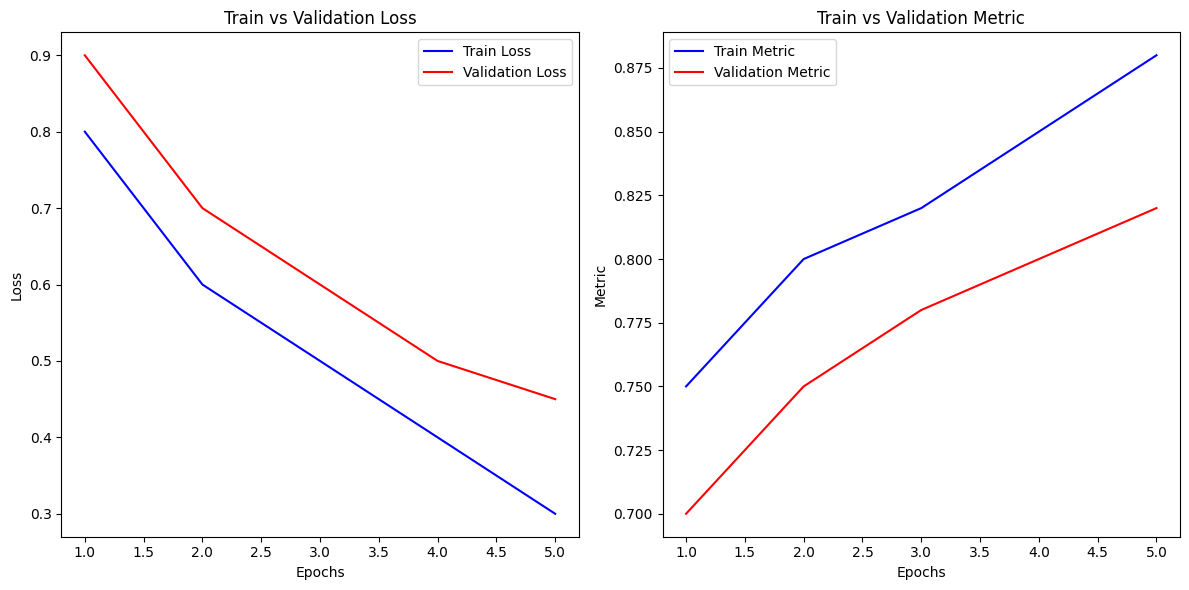

In [ ]:
def plot_loss_and_metric(train_loss, val_loss, train_metric=None, val_metric=None, epochs=10, metric_name="Metric"):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", color="blue")
    plt.plot(range(1, epochs + 1), val_loss, label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()

    if train_metric is not None and val_metric is not None:
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_metric, label="Train " + metric_name, color="blue")
        plt.plot(range(1, epochs + 1), val_metric, label="Validation " + metric_name, color="red")
        plt.xlabel("Epochs")
        plt.ylabel(metric_name)
        plt.title(f"Train vs Validation {metric_name}")
        plt.legend()

    plt.tight_layout()
    plt.show()

###############чисто для проверки###############
train_loss = [0.8, 0.6, 0.5, 0.4, 0.3]
val_loss = [0.9, 0.7, 0.6, 0.5, 0.45]
train_metric = [0.75, 0.8, 0.82, 0.85, 0.88]
val_metric = [0.7, 0.75, 0.78, 0.8, 0.82]

plot_loss_and_metric(train_loss, val_loss, train_metric, val_metric, epochs=5)


## **Задание №2.** Модель для задачи мультирегрессии на выбраных вами данных.

In [ ]:
samples = 50000
features = 10
targets = 3

In [ ]:
W_true = np.random.randn(targets, features).astype(np.float32) * 2
b_true = np.random.randn(targets).astype(np.float32) * 5

In [ ]:
X_reg = np.random.rand(samples, features).astype(np.float32) * 10

y_reg = (
    X_reg @ W_true.T
    + b_true
    + np.random.randn(samples, targets).astype(np.float32) * 0.5
).astype(np.float32)

In [ ]:
scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(X_reg)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
def build_regression_model(input_features, output_targets, layer_size, num_layers, activation_function=ReLU, dropout_rate=0.0):
    network = Sequential()
    prev_size = input_features

    for _ in range(num_layers):
        network.add(Linear(prev_size, layer_size))
        network.add(BatchNormalization())
        network.add(ChannelwiseScaling(layer_size))
        network.add(activation_function())

        if dropout_rate > 0:
            network.add(Dropout(dropout_rate))

        prev_size = layer_size

    network.add(Linear(prev_size, output_targets))
    return network

In [ ]:
small = build_regression_model(input_features=features, output_targets=targets, layer_size=32, num_layers=1, activation_function=ReLU, dropout_rate=0.1)

medium = build_regression_model(input_features=features, output_targets=targets, layer_size=64, num_layers=2, activation_function=ELU, dropout_rate=0.2)

large = build_regression_model(input_features=features, output_targets=targets, layer_size=128, num_layers=3, activation_function=Gelu, dropout_rate=0.3)

Обучим одну из моделей. Делается так из побуждений, что все одинаково в написании

In [ ]:
criterion = MSECriterion()
optimizer = Adam(small.getParameters(), lr=1e-3, wd=1e-4)
scheduler = StepLearningRateScheduler(optimizer, step_interval=10, decay_factor=0.5)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs, batch_size):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        num_batches = len(X_train) // batch_size

        for batch_idx in range(num_batches):
            batch_start = batch_idx * batch_size
            batch_end = (batch_idx + 1) * batch_size

            X_batch = X_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]

            model_output = model.forward(X_batch)

            loss = criterion.forward(model_output, y_batch)

            model.zeroGradParameters()
            grad_output = criterion.backward(model_output, y_batch)
            model.backward(grad_output)

            optimizer.step()

            epoch_loss += loss

        scheduler.update_lr()

## **Задача №3.** Модель для задачи мультиклассификации на MNIST.

In [ ]:
train_data = MNIST(root="./data", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="./data", train=False, download=True, transform=ToTensor())

X_train_val = train_data.data.numpy().astype(np.float32)
X_test = test_data.data.numpy().astype(np.float32)
y_train_val = train_data.targets.numpy()
y_test = test_data.targets.numpy()

mean, std = np.mean(X_train_val, axis=(0, 1, 2), keepdims=True), np.std(X_train_val, axis=(0, 1, 2), keepdims=True)
X_train_val = (X_train_val - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)

X_train_val, X_test = X_train_val[:, None, :, :], X_test[:, None, :, :]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

In [ ]:
def create_classification_model():
    model = Sequential()

    model.add(Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2))
    model.add(ReLU())
    model.add(MaxPool2d(kernel_size=2, stride=2, padding=1))

    model.add(Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1))
    model.add(ReLU())
    model.add(MaxPool2d(kernel_size=2, stride=2, padding=1))

    model.add(Flatten())

    model.add(Linear(n_in=16 * 7 * 7, n_out=128))
    model.add(ReLU())
    model.add(Dropout(0.25))

    model.add(Linear(n_in=128, n_out=10))
    model.add(SoftMax())

    return model

In [ ]:

model_clf = create_classification_model()

*и тут должно быть обучение......*

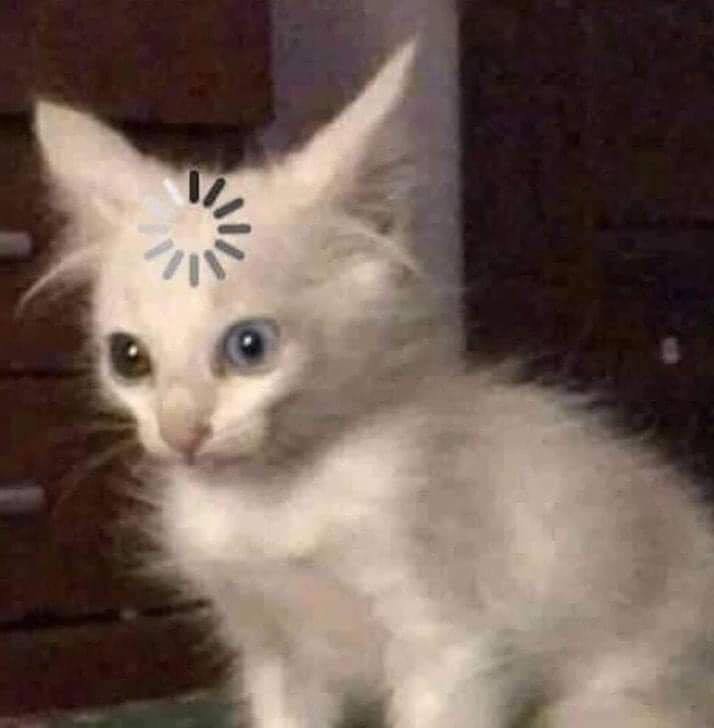